In [1]:
''' use pca to extract characteristic of signal
then use dnn+Res to fit; probably voigt function/Gaussian line shape'''
import os  
import numpy as np
import struct
import matplotlib.pyplot as plt
import gc
import random
import math
from tensorflow import keras
import sklearn
# from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA as PCA

In [2]:
with open("dataset_test.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig2 = np.zeros((NM1,200),dtype = np.float32)
    an2 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an2[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig2[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

In [3]:
with open("dataset.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig1 = np.zeros((NM1,200),dtype = np.float32)
    an1 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an1[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig1[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

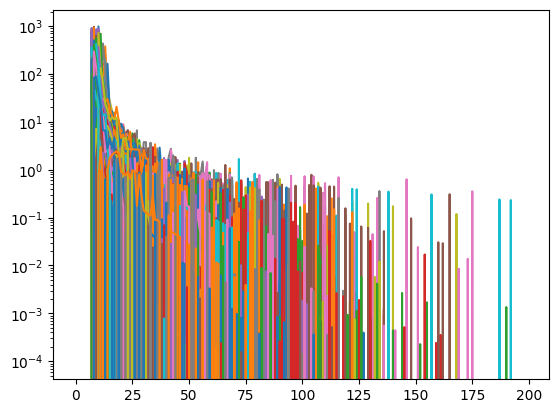

1262
[1.24224685e-02 9.14926987e+01 1.54261023e+03 8.50000024e-01]


In [4]:
plt.axes(yscale = "log") 
for n in range(sig1.shape[0]):
    plt.plot(sig1[n])
plt.show()
print(NM1)
print(an2[-1])

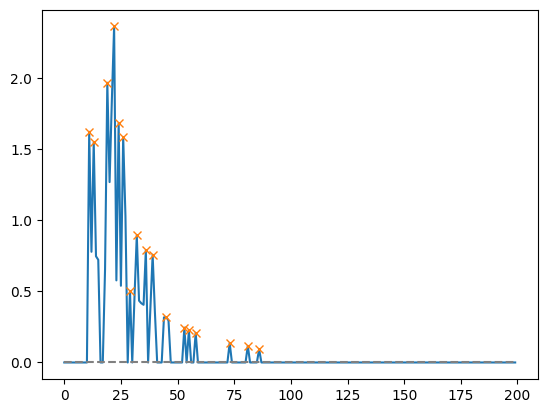

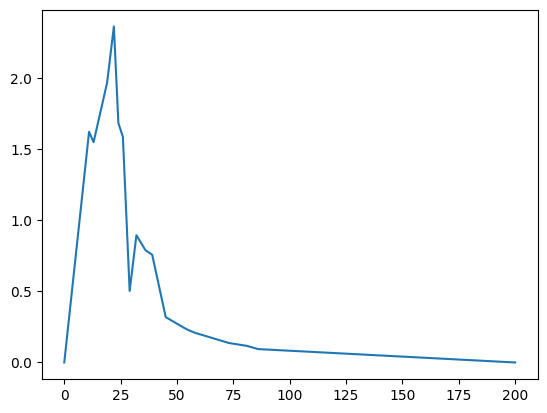

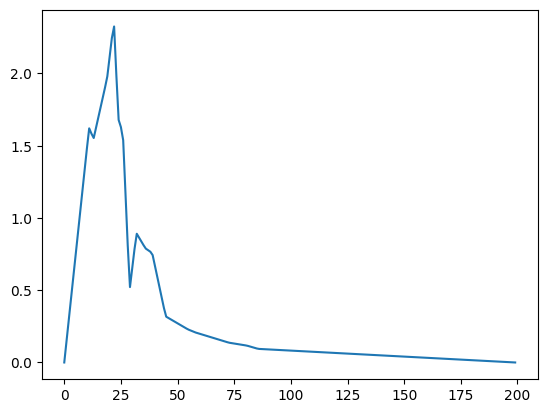

In [5]:
xsig = sig1[0]
peaks, _ = find_peaks(xsig, height=0)
plt.plot(xsig)
plt.plot(peaks, xsig[peaks], "x")
plt.plot(np.zeros_like(xsig), "--", color="gray")
plt.show()

x = np.zeros((peaks.shape[0]+2,))
y = np.zeros((peaks.shape[0]+2,))
x[1:-1] = peaks
y[1:-1] = xsig[peaks]
x[-1] = sig1.shape[1]
plt.plot(x,y)
plt.show()

f2 = interp1d(x, y, kind='linear')
N = 200
xnew = np.linspace(0, N,num=N)
ynew = f2(xnew)

# plt.axes(yscale = "log") 
plt.plot(ynew)
plt.show()

In [6]:
def smooth_peak(xsig):
    peaks, _ = find_peaks(xsig, height=0)
    # plt.plot(xsig)
    # plt.plot(peaks, xsig[peaks], "x")
    # plt.plot(np.zeros_like(xsig), "--", color="gray")
    # plt.show()
    if(peaks.shape[0]!=0):
        x = np.zeros((peaks.shape[0]+3,))
        y = np.zeros((peaks.shape[0]+3,))
        x[1:-2] = peaks
        y[1:-2] = xsig[peaks]
        x[-1] = sig1.shape[1]
        y[-1] = 0
        x[-2] = peaks[-1]+5
        y[-2] = 0
        # plt.plot(x,y)
        # plt.show()

        f2 = interp1d(x, y, kind='linear')
        N = xsig.shape[0]
        xnew = np.linspace(0, N,num=N)
        ynew = f2(xnew)
    
    else:
        ynew = np.zeros((xsig.shape[0],))
    
    return ynew
#     # plt.axes(yscale = "log") 
#     plt.plot(ynew)
#     plt.show()
    

In [7]:
msig1 = np.zeros((sig1.shape[0],sig1.shape[1]))
for i in range(sig1.shape[0]):
    msig1[i] = smooth_peak(sig1[i])
    
msig2 = np.zeros((sig2.shape[0],sig2.shape[1]))
for i in range(sig2.shape[0]):
    msig2[i] = smooth_peak(sig2[i])

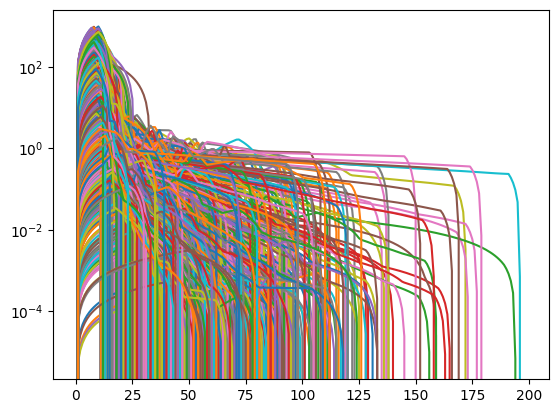

In [8]:
plt.axes(yscale = "log") 
for n in range(msig1.shape[0]):
    plt.plot(msig1[n])
plt.show()

In [9]:
print(sig1.shape)
print(an1.shape)
print(sig2.shape)
print(an2.shape)
# num_labels = 10
x_train = msig1
y_train = an1   # y_train : [thickness,mua,mus,g]
x_test = msig2
y_test = an2

x_train = (np.log10((x_train+1e-6)/1000)+9)/9   # 归一化
x_test = (np.log10((x_test+1e-6)/1000)+9)/9

n_components = 4
pca = PCA(n_components)
pca.fit(x_train)
# 转换数据并提取主成分
features = pca.transform(x_train)       # PCA
loading = pca.components_
x_train = features

n_components = 4
pca = PCA(n_components)
pca.fit(x_test)
# 转换数据并提取主成分
features = pca.transform(x_test)
loading = pca.components_
x_test = features

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))    # reshape
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
d_train = np.reshape(y_train[:,0],(y_train[:,0].shape[0],1,1)) # add thickness of sample into input data
d_test = np.reshape(y_test[:,0],(y_test[:,0].shape[0],1,1))

y_train[:,1] = y_train[:,1]/1e2
y_test[:,1] = y_test[:,1]/1e2
y_train[:,2] = y_train[:,2]/200e2
y_test[:,2] = y_test[:,2]/200e2
y_train = y_train[:,1:3] # determine the nn to output mua/mus or mua+mus
y_test = y_test[:,1:3]
# y_train = labeling(y_train,num_labels)[:,1,:] # select to predict what : 0:thickness 1:mua 2: mus
# y_test = labeling(y_test,num_labels)[:,1,:]
print('x_train.shape = '+str(x_train.shape)) 
print('y_train.shape = '+str(y_train.shape)) 
print('d_train.shape = '+str(d_train.shape)) 


(1262, 200)
(1262, 4)
(30, 200)
(30, 4)
x_train.shape = (1262, 4, 1)
y_train.shape = (1262, 2)
d_train.shape = (1262, 1, 1)


In [16]:
inputs1 = keras.layers.Input(shape=(4, 1))
inputs2 = keras.layers.Input(shape=(1,))
x = inputs1
# x = keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(x)
# x = keras.layers.MaxPooling1D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
concat = keras.layers.concatenate([x, inputs2])
x = keras.layers.Dense(128, activation='relu')(concat)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
concat = keras.layers.Reshape((-1,5,1))(concat)
concat= keras.layers.Conv1D(filters=64, kernel_size=1, padding="same")(concat)
x = x + concat
x = keras.layers.ReLU()(x)
outputs = keras.layers.Dense(2, activation='linear')(x)
model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs)




ValueError: The `padding` argument must be a list/tuple or one of "valid", "same" (or "causal", only for `Conv1D). Received: zero

In [15]:
epochs = 500
batch_size = 32
#####################################################
index = [i for i in range(x_train.shape[0])]  
np.random.shuffle(index) 
x_train = x_train[index]
y_train = y_train[index]
d_train = d_train[index]
####################################################
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    # loss="mean_squared_error",
    loss="mean_absolute_error",
    metrics=["MeanAbsoluteError"],
)
history = model.fit(
    [x_train,d_train],
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.4,
    verbose=1,
)

Epoch 1/500


InvalidArgumentError:  required broadcastable shapes
	 [[node model/tf.__operators__.add_1/AddV2 (defined at C:\Users\Administrator\AppData\Local\Temp\ipykernel_11044\498885064.py:25) ]] [Op:__inference_train_function_1512]

Function call stack:
train_function


In [74]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate([x_test,d_test,], y_test)

print("Test error", test_acc)
print("Test loss", test_loss)

1/1 [==============================] - 0s 90ms/step - loss: 0.2244 - mean_absolute_error: 0.2244
Test error 0.2244032472372055
Test loss 0.2244032472372055


In [75]:
mua = np.zeros((x_train.shape[0],))
# mus = np.zeros((x_train.shape[0],))
d = np.zeros((x_train.shape[0],))
miu = np.zeros((x_train.shape[0],1))

miu = model.predict([x_train,d_train])
mua = miu[:,0]
mus = miu[:,1]
d = d_train[:,0,0]

In [76]:
err = np.zeros((x_train.shape[0],2))

err[:,0] = y_train[:,0]-mua
err[:,1] = y_train[:,1]-mus

# print(mua[k],mus[k],d[k])
# print(y_train[k])

In [77]:
k=np.random.randint(0,x_train.shape[0],1)[0]
print(mua[k],mus[k])
print(y_train[k])

0.73388696 0.5626644
[0.8221224 0.6947891]


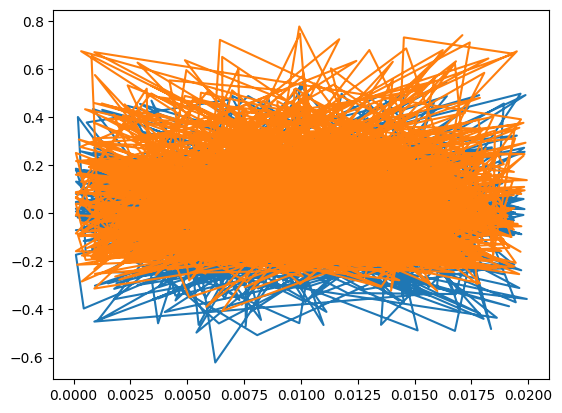

In [78]:
plt.plot(d,err[:,0])
plt.plot(d,err[:,1])
plt.show()

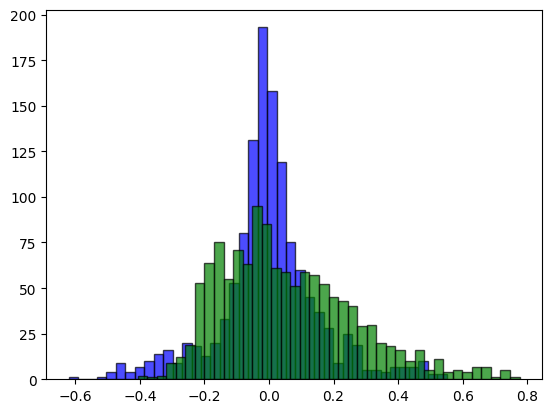

In [79]:
# print(mua,mus,d)
# print(an2[i,1],an2[i,2],an2[i,0])
# plt.plot(abs(an1[:,1]-mua))
# plt.plot(abs(an1[:,2]-mus))
plt.hist(err[:,0], bins=40,  facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(err[:,1], bins=40,  facecolor="green", edgecolor="black", alpha=0.7)
# plt.hist(abs(y_train[:,1]-mus), bins=40,  facecolor="green", edgecolor="black", alpha=0.7)
plt.show()

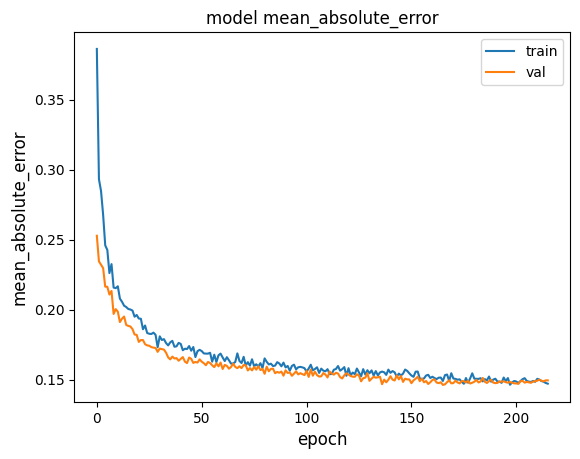

In [80]:
metric = "mean_absolute_error"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()